# WNS Analytics Wizard 2019

<b>About WNS</b>

WNS (Holdings) Limited (NYSE: WNS) is a leading Business Process Management (BPM) company. WNS combines deep industry knowledge with technology, analytics and process expertise to co-create innovative, digitally led transformational solutions with over 350 clients across various industries. It is a trusted analytics partner to over 90+ clients from banking, insurance, hospitality, retail, CPG, logistics, healthcare providers, airlines and many more. WNS leverages its analytics expertise in combination with rich industry domain knowledge and custom-built proprietary frameworks to help clients make informed decisions at the right time. It has more than a decade of proven, core analytics experience with over 2,700+ analytics professionals spread across 16+ delivery centers. For more information, visit https://www.wns.com/solutions/functional-solutions/analytics

# Problem Statement

Zbay is an E-commerce website which sells a variety of products at its online platform. Zbay records user behaviour of its customers and stores it as a log. However, most of the times, users do not buy the products instantly and there is a time gap during which the customer might surf the internet and maybe visit competitor websites.

 

Now, to improve sales of products, Zbay has hired Adiza, an Adtech company which built a system such that ads are being shown for Zbay’s products on its partner websites.

 

If a user comes to Zbay’s website and searches for a product, and then visits these partner websites or apps, his/her previously viewed items or their similar items are shown on as an ad. If the user clicks this ad, he/she will be redirected to the Zbay’s website and might buy the product.

In this problem, the task is to predict click probability i.e. probability of user clicking the ad which is shown to them on the partner websites for the next 7 days on the basis of historical view log data, ad impression data and user data.

 

You are provided with the view log of users (2018/10/15 - 2018/12/11) and the product description collected from the Zbay website. We also provide the training data and test data containing details for ad impressions at the partner websites(Train + Test).

 

Train data contains the impression logs during 2018/11/15 – 2018/12/13 along with the label which specifies whether the ad is clicked or not. Your model will be evaluated on the test data which have impression logs during 2018/12/12 – 2018/12/18 without the labels.

# Dataset Description

### Train

<b>impression_id</b>:      	AD impression id<br>
<b>impression_time</b>:    	Time of the impression at partner website<br>
<b>user_id</b>:            	user id<br>
<b>app_code</b>:	Application Code for a partner website where the ad was shown<br>
<b>os_version</b>:	Version of operating system<br>
<b>is_4G</b>:	1-Using 4G, 0-No 4G<br>
<b>is_click	(target): Whether user clicked the AD (1-click, 0-no click) </b> <br>

### view log

<b>server_time</b>:	Timestamp of the log<br>
<b>device_type</b>:	Device type of the user<br>
<b>session_id</b>:	Browser session id<br>
<b>user_id</b>:	user id<br>
<b>item_id</b>:	Item id  <br>

### Item data

<b>item_id</b>:	Item id<br>
<b>item_price</b>:	Price of the item<br>
<b>category_1</b>:	Category depth 1<br>
<b>category_2</b>:	Category depth 2<br>
<b>category_3</b>:	Category depth 3<br>
<b>product_type</b>:	anonymized item type<br>

In [73]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Algorithms
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

In [74]:
# Reading train files
os.chdir('D:\Data Science\WNS Hackathon')
train = pd.read_csv('train.csv')
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,15-11-2018 0.00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,15-11-2018 0.01,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,15-11-2018 0.02,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,15-11-2018 0.02,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,15-11-2018 0.02,62873,473,latest,0,0


In [75]:
#to display all columns in the dataset
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [76]:
train.shape

(237609, 7)

In [77]:
train.impression_time.values   #to check the format

array(['15-11-2018 0.00', '15-11-2018 0.01', '15-11-2018 0.02', ...,
       '13-12-2018 7.42', '13-12-2018 7.43', '13-12-2018 7.43'],
      dtype=object)

In [78]:
from datetime import datetime as dt

# Splitting date time column into two individual columns
train['impression_time'] = pd.to_datetime(train['impression_time'], format='%d-%m-%Y %H.%M', errors='coerce')
train.impression_time[0]   #to check whether it gets converted

Timestamp('2018-11-15 00:00:00')

In [79]:
train['time_in_minutes'] = train['impression_time'].dt.hour * 60 + train['impression_time'].dt.minute + train['impression_time'].dt.second/60

In [80]:
train.head(6)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,time_in_minutes
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0.0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1.0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,2.0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,2.0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,2.0
5,3416a75f4cea9109507cacd8e2f2aefc,2018-11-15 00:03:00,67352,409,latest,1,0,3.0


In [81]:
#train['train_Date'] = train['impression_time'].dt.day
#train['train_Month'] = train['impression_time'].dt.month
#train['Train_Time'] = train['impression_time'].dt.time
#train['train_Hour_of_the_day'] = train['impression_time'].dt.hour

In [82]:
item_data = pd.read_csv('item_data.csv')
item_data.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [83]:
view_log = pd.read_csv('view_log.csv')
view_log.head()

,server_time,device_type,session_id,user_id,item_id
0,15-10-2018 8.58,android,112333,4557,32970
1,15-10-2018 8.58,android,503590,74788,7640
2,15-10-2018 8.58,android,573960,23628,128855
3,15-10-2018 8.58,android,121691,2430,12774
4,15-10-2018 8.58,android,218564,19227,28296


In [84]:
# Parsing dates as datetime

view_log.server_time = pd.to_datetime(view_log.server_time, format='%d-%m-%Y %H.%M', errors='coerce')
view_log.server_time[0]

Timestamp('2018-10-15 08:58:00')

In [85]:
view_log['view_in_minutes'] = view_log['server_time'].dt.hour * 60 + view_log['server_time'].dt.minute + view_log['server_time'].dt.second/60

In [86]:
#view_log['log_Date'] = view_log['server_time'].dt.day
#view_log['log_Month'] = view_log['server_time'].dt.month
#view_log['log_Hour'] = view_log['server_time'].dt.hour

In [87]:
view_log.head(6)

,server_time,device_type,session_id,user_id,item_id,view_in_minutes
0,2018-10-15 08:58:00,android,112333,4557,32970,538.0
1,2018-10-15 08:58:00,android,503590,74788,7640,538.0
2,2018-10-15 08:58:00,android,573960,23628,128855,538.0
3,2018-10-15 08:58:00,android,121691,2430,12774,538.0
4,2018-10-15 08:58:00,android,218564,19227,28296,538.0
5,2018-10-15 08:58:00,android,635314,87387,86660,538.0


In [88]:
# Reading test files
test = pd.read_csv('test.csv')
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,13-12-2018 7.44,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,13-12-2018 7.45,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,13-12-2018 7.46,25234,296,latest,1
3,39c4b4dc0e9701b55a0a4f072008fb3f,13-12-2018 7.47,22988,207,latest,1
4,bf5a572cca75f5fc67f4b14e58b11d70,13-12-2018 7.48,35431,242,latest,1


In [89]:
# Coverting columns from test dataset to Date time format

test['impression_time'] = pd.to_datetime(test['impression_time'], format='%d-%m-%Y %H.%M', errors='coerce')
test.impression_time[0]

Timestamp('2018-12-13 07:44:00')

In [90]:
test['test_time_in_minutes'] = test['impression_time'].dt.hour * 60 + test['impression_time'].dt.minute + test['impression_time'].dt.second/60

In [91]:
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,test_time_in_minutes
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,464.0
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,465.0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1,466.0
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1,467.0
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1,468.0


<b>Let's merge train, item_data and view_logs datasets to get more insights.

In [92]:
data = train.merge(view_log, on = 'user_id').merge(item_data, on = 'item_id')
data.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,time_in_minutes,server_time,device_type,session_id,item_id,view_in_minutes,item_price,category_1,category_2,category_3,product_type
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0.0,2018-10-19 18:11:00,android,190710,43886,1091.0,2350,11,35,20,5622
1,621bf66ddb7c962aa0d22ac97d69b793,2018-11-15 00:19:00,87862,422,old,0,0,19.0,2018-10-19 18:11:00,android,190710,43886,1091.0,2350,11,35,20,5622
2,ab394288aed46588bdc90bf4b541ec0d,2018-11-16 17:29:00,87862,422,old,0,0,1049.0,2018-10-19 18:11:00,android,190710,43886,1091.0,2350,11,35,20,5622
3,372d3f309fef061977fb2f7ba36d74d2,2018-11-15 06:11:00,85131,207,latest,1,0,371.0,2018-10-15 13:25:00,android,663666,43886,805.0,2350,11,35,20,5622
4,edff941bff2b709d9aa7200cf131f06b,2018-12-03 06:56:00,85131,207,latest,1,0,416.0,2018-10-15 13:25:00,android,663666,43886,805.0,2350,11,35,20,5622


In [93]:
data.columns

Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
       'is_4G', 'is_click', 'time_in_minutes', 'server_time', 'device_type',
       'session_id', 'item_id', 'view_in_minutes', 'item_price', 'category_1',
       'category_2', 'category_3', 'product_type'],
      dtype='object')

# EDA - Plotting

<b>Let's plot os_version v/s is_click

In [94]:
os_vs_is_click = pd.crosstab(data.os_version, data.is_click)
os_vs_is_click

is_click,0,1
os_version,,
intermediate,885689,63562
latest,1790801,90247
old,806616,51309


Text(0, 0.5, 'Count')

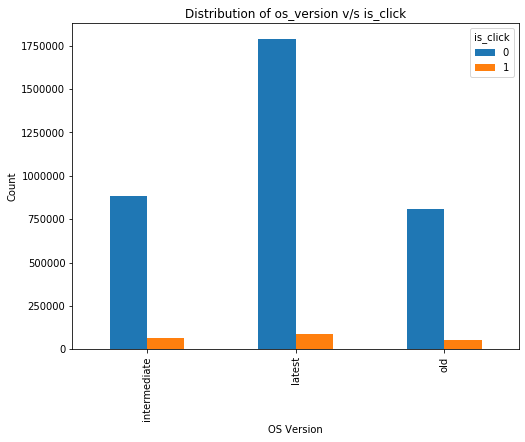

In [95]:
os_vs_is_click.plot(kind = 'bar', figsize = (8, 6))
plt.title('Distribution of os_version v/s is_click')
plt.xlabel('OS Version')
plt.ylabel('Count')

<b>Let's plot 4G v/s is_click

In [96]:
is_4G_vs_is_click = pd.crosstab(data.is_4G, data.is_click)
is_4G_vs_is_click

is_click,0,1
is_4G,,
0,2419494,147256
1,1063612,57862


<b>Let's plot it

Text(0, 0.5, 'Count')

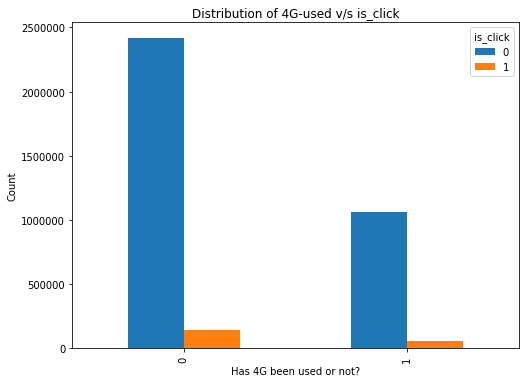

In [97]:
is_4G_vs_is_click.plot(kind = 'bar', figsize = (8, 6))
plt.title('Distribution of 4G-used v/s is_click')
plt.xlabel('Has 4G been used or not?')
plt.ylabel('Count')

<b>Let's analyze user_id: How many times have they come across an ad

In [98]:
data.groupby('impression_id')['user_id'].unique()

impression_id
00003e3b9e5336685200ae85d21b4f5e    [38051]
0000b2815cc3c2b56867cbbf4d36efa5    [16990]
0001261e2060303a06ba6c64d676d639    [8726] 
00017961865c4f766fdbb3cd8fe0bfb0    [4431] 
00019d812c1173c8a69c656a40fa8767    [24014]
                                     ...   
fffee5badc626a2ab8086120712e5639    [58525]
ffff748a7ac35759d9fef57a34fd4a21    [20065]
ffffb8de2d77567f452ad766471a9e5e    [88195]
ffffda8ada4827900cbf65fd20281080    [42490]
fffffe98d0963d27015c198262d97221    [3780] 
Name: user_id, Length: 171485, dtype: object

<b>Let's check whether visitors had bought any item before coming across an ad on partner website

In [99]:
data.groupby('user_id')['item_id'].count()

user_id
0        9  
2        404
3        8  
8        37 
10       54 
         .. 
92578    2  
92580    24 
92581    5  
92583    4  
92585    5  
Name: item_id, Length: 50417, dtype: int64

<b>Let's analyze click rate with time

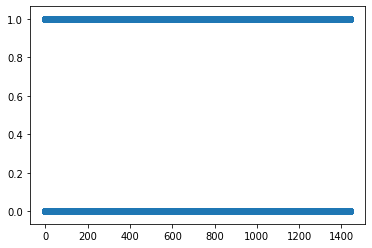

In [100]:
plt.scatter(data.time_in_minutes, data.is_click)

<b>Let's check if the customer shopped before seeing the impression

In [101]:
data.groupby(['server_time', 'user_id'])['item_id'].agg('count')

server_time          user_id
2018-10-15 08:58:00  348        4 
                     2430       13
                     4557       2 
                     19227      2 
                     23628      2 
                               .. 
2018-11-05 12:22:00  74034      6 
                     85283      1 
                     85699      5 
                     90478      2 
                     91937      5 
Name: item_id, Length: 782454, dtype: int64

<b>The above code gives us an idea of no. of items bought by customers from the website before coming across the ad impression elsewhere

<b>Let's check the no. of items browsed by the visitor before shopping

In [102]:
data.groupby(['server_time','user_id', 'item_id'])['category_1'].agg('count')

server_time          user_id  item_id
2018-10-15 08:58:00  348      35370      4 
                     2430     12774      13
                     4557     32970      2 
                     19227    28296      1 
                              100065     1 
                                        .. 
2018-11-05 12:22:00  85283    110616     1 
                     85699    93404      5 
                     90478    87943      1 
                              116326     1 
                     91937    9020       5 
Name: category_1, Length: 870511, dtype: int64

<b>Let's check if item price was changed over time

In [103]:
data.groupby(['item_id', 'server_time'])['item_price'].agg('sum')

item_id  server_time        
0        2018-10-22 19:17:00    2873  
2        2018-10-16 08:42:00    776720
         2018-10-31 13:22:00    22192 
3        2018-10-29 00:47:00    69888 
         2018-10-29 16:31:00    69888 
                                ...   
132865   2018-10-18 20:05:00    480   
         2018-10-19 11:04:00    960   
         2018-10-20 21:53:00    960   
         2018-10-23 20:11:00    480   
         2018-10-23 20:48:00    480   
Name: item_price, Length: 811200, dtype: int64

In [104]:
# Checking class imbalance

train['is_click'].value_counts()

0    226747
1    10862 
Name: is_click, dtype: int64

In [105]:
# Displaying in %

((train['is_click'].value_counts(normalize = True))*100).round(2)

0    95.43
1    4.57 
Name: is_click, dtype: float64

In [106]:
print('Ratio of majority to minority is around 95:5')

Ratio of majority to minority is around 95:5


### Like, we can see a class imbalance, let's remove it using different sampling methods

# One Hot Encoding

<b>Encoding train dataset

In [107]:
# Let's use One Hot encoding to convert categorical to numerical variables

train.select_dtypes(exclude=["number","bool_"]).head()

,impression_id,impression_time,os_version
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,old
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,latest
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,intermediate
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,latest
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,latest


<b> Impression id is an unique variable which will have multiple sub values so we can drop it. Both date-time columns have been converted to give us time in minutes hence can be dropped. In case of device type and os_version, let's check how many sub values does it have

In [108]:
train.os_version.value_counts()

latest          129216
intermediate    55543 
old             52850 
Name: os_version, dtype: int64

Let's one hot encode them to convert them into numerical values

In [109]:
data_onehot = train[['os_version']]

In [110]:
from sklearn.preprocessing import OneHotEncoder

In [111]:
enc = OneHotEncoder(sparse = False)

In [112]:
enc.fit(data_onehot)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=False)

In [113]:
data_onehot_transformed = enc.transform(data_onehot)

In [114]:
data_onehot_transformed

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [115]:
data_onehot_transformed.shape

(237609, 3)

In [116]:
data2 = pd.DataFrame(data_onehot_transformed)

In [117]:
data2.head()  # Displaying ine hot encoded data

,0,1,2
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [118]:
# Concatenating original data with one hot encoded data

train = pd.concat([train, data2], axis = 1)

In [119]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,time_in_minutes,0,1,2
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,0.0,0.0,0.0,1.0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1.0,0.0,1.0,0.0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,2.0,1.0,0.0,0.0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,2.0,0.0,1.0,0.0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,2.0,0.0,1.0,0.0


Let's drop impression_id, impression_time and os_version

In [120]:
train.drop(['impression_id', 'os_version', 'impression_time'], axis = 1, inplace = True)

In [121]:
train.head()

,user_id,app_code,is_4G,is_click,time_in_minutes,0,1,2
0,87862,422,0,0,0.0,0.0,0.0,1.0
1,63410,467,1,1,1.0,0.0,1.0,0.0
2,71748,259,1,0,2.0,1.0,0.0,0.0
3,69209,244,1,0,2.0,0.0,1.0,0.0
4,62873,473,0,0,2.0,0.0,1.0,0.0


In [122]:
# To check whether all columns are int/float

train.dtypes

user_id            int64  
app_code           int64  
is_4G              int64  
is_click           int64  
time_in_minutes    float64
0                  float64
1                  float64
2                  float64
dtype: object

<b>Encoding test dataset

In [123]:
test.select_dtypes(exclude = ['number','bool_']).head()

,impression_id,impression_time,os_version
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,latest
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,latest
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,latest
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,latest
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,latest


In [124]:
data_test_encode = test[['os_version']]

In [125]:
enc_test = OneHotEncoder(sparse = False)

In [126]:
enc_test.fit(data_test_encode)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=False)

In [127]:
data_onehot_transformed_test = enc.transform(data_test_encode)

In [128]:
data_onehot_transformed_test

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [129]:
data_onehot_transformed_test.shape

(90675, 3)

In [130]:
data2_test = pd.DataFrame(data_onehot_transformed_test)
data2_test.head()  # Displaying one hot encoded data

,0,1,2
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [131]:
# Concatenating original data with one hot encoded data

test = pd.concat([test, data2_test], axis = 1)

In [132]:
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,test_time_in_minutes,0,1,2
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,464.0,0.0,1.0,0.0
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,465.0,0.0,1.0,0.0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1,466.0,0.0,1.0,0.0
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1,467.0,0.0,1.0,0.0
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1,468.0,0.0,1.0,0.0


Let's drop impression_id, impression_time and os_version

In [133]:
test.drop(['impression_id', 'os_version', 'impression_time'], axis = 1, inplace = True)

In [134]:
test.head()

,user_id,app_code,is_4G,test_time_in_minutes,0,1,2
0,44754,127,1,464.0,0.0,1.0,0.0
1,29656,44,0,465.0,0.0,1.0,0.0
2,25234,296,1,466.0,0.0,1.0,0.0
3,22988,207,1,467.0,0.0,1.0,0.0
4,35431,242,1,468.0,0.0,1.0,0.0


In [135]:
# To check whether all columns are int/float

test.dtypes

user_id                 int64  
app_code                int64  
is_4G                   int64  
test_time_in_minutes    float64
0                       float64
1                       float64
2                       float64
dtype: object

# Clustering

In [136]:
train.is_click.value_counts()

0    226747
1    10862 
Name: is_click, dtype: int64

# Up Sampled minority class

In [137]:
# Let's shuffle the data to maintain a certain level of accuracy

train = train.sample(frac = 1)

In [138]:
from sklearn.utils import resample

# Let's seperate out both classes as seperate dataframes

data_minority = train[train.is_click == 1]
data_minority.shape

(10862, 8)

In [139]:
data_majority = train[train.is_click == 0]
data_majority.shape

(226747, 8)

In [140]:
# Shuffle dataframe rows
new_df = data_minority.sample(226747, replace = True)

new_df.shape

(226747, 8)

In [141]:
normal_distributed_df = pd.concat([data_majority, new_df], axis = 0)

In [142]:
normal_distributed_df.is_click.value_counts(normalize = True)

1    0.5
0    0.5
Name: is_click, dtype: float64

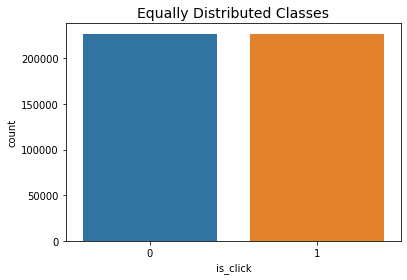

In [143]:
#Let's plot the above result

sns.countplot('is_click', data = normal_distributed_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [144]:
# Using over sampled minority class dataset
normal_distributed_df.head()

,user_id,app_code,is_4G,is_click,time_in_minutes,0,1,2
126358,52592,168,0,0,410.0,0.0,1.0,0.0
121657,17960,371,0,0,530.0,0.0,1.0,0.0
195360,62820,213,0,0,1338.0,0.0,0.0,1.0
206990,45939,463,0,0,534.0,0.0,1.0,0.0
44833,6708,320,0,0,1204.0,1.0,0.0,0.0


In [ ]:
X_upsample = normal_distributed_df.drop(['is_click'], axis = 1)

In [ ]:
y_upsample = normal_distributed_df['is_click']

<b>Let's fit a Random Forest Classifier

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
ran = RandomForestClassifier()

In [ ]:
ran.fit(X_ros, y_ros)

In [ ]:
ran_pred = ran.predict(X_test[0:226747:])

In [ ]:
# Let's check whether our model is predicting both the classes or not?
print(np.unique(ran_pred))

<b>Let's measure accuracy and area under ROC

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy Score from Random Forest is: ', accuracy_score(y, ran_pred))

# Down-sample Majority Class

In [ ]:
data_majority_downsampled = data_majority.sample(10862) # reproducible results

In [ ]:
# Combine minority class with downsampled majority class
data_downsampled = pd.concat([data_majority_downsampled, data_minority])

In [ ]:
data_downsampled.is_click.value_counts(normalize = True)

In [ ]:
#Let's plot the above result

sns.countplot('is_click', data = data_downsampled)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## Spliting train into X & Y

In [ ]:
# Separate input features (X) and target variable (y)
y = train.is_click
X = train.drop('is_click', axis=1)
#X = X[:10862]
print(X.shape)
print(y.shape)

## Assigning test data as X_test

In [ ]:
X_test = test
X_test.shape

# SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12, ratio = 1.0)

In [ ]:
x_train_res, y_train_res = sm.fit_sample(X, y)

# Normalize the data

<b>Normalizing train data

In [ ]:
#from sklearn.preprocessing import StandardScaler
#X = StandardScaler().fit(X).transform(X)
#X

<b>Normalizing test data

In [ ]:
#from sklearn.preprocessing import StandardScaler
#X_test = StandardScaler().fit(X_test).transform(X_test)
#X_test

### Splitting sampled df into X and y

In [ ]:
X_sampled = normal_distributed_df.drop('is_click')

# SVC - Penalized SVM

In [ ]:
# Train model
clf_3 = SVC(kernel='linear', class_weight='balanced', probability=True)
 
clf_3.fit(X, y)

In [ ]:
# Predict on training set
"""pred_y_3 = clf_3.predict(X)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_3 ) )
# [0 1]
 
# How's our accuracy?
print( accuracy_score(y, pred_y_3) )
# 0.688
 
# What about AUROC?
prob_y_3 = clf_3.predict_proba(X)
prob_y_3 = [p[1] for p in prob_y_3]
print( roc_auc_score(y, prob_y_3) ) """